In [4]:
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit_optimization import QuadraticProgram
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP, CRS
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver  # For an exact (classical) minimum eigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer  # Qiskit's wrapper to use eigensolvers with optimization problems

num_assets = 10 # set number of assets (= number of qubits)

In [5]:
from pyqubo import Binary
import numpy as np
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import TwoLocal

# Generate data

In [6]:

np.random.seed(42)
n_properties = 10
budget = 3

# Step 1: Set a known optimal bitstring (with exactly `budget` ones)
X_opt = np.zeros(n_properties)
X_opt[[1, 4, 7]] = 1  # you choose these positions
X_opt = X_opt.astype(int)

# Step 2: Generate premiums (mu)
mu = np.random.uniform(0.05, 0.15, n_properties)

# Boost the premiums of the "true" optimal ones
mu[X_opt == 1] += 0.2  # make them significantly more attractive

# Step 3: Build a correlation matrix (sigma)
# Low correlation between selected properties
base_corr = np.random.uniform(0.1, 0.3, (n_properties, n_properties))
correlation_matrix = (base_corr + base_corr.T) / 2
np.fill_diagonal(correlation_matrix, 1)

# Now, add stronger correlation between non-optimal properties to make them riskier
for i in range(n_properties):
    for j in range(n_properties):
        if X_opt[i] == 0 and X_opt[j] == 0 and i != j:
            correlation_matrix[i, j] += 0.3  # make non-selected more correlated

# Step 4: Turn into covariance-like structure
sigma = correlation_matrix * np.outer(mu, mu)

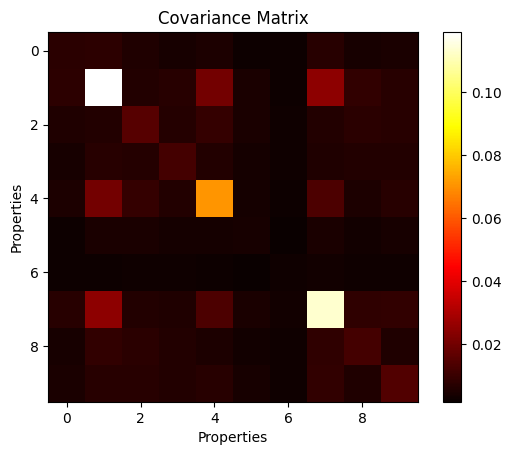

In [7]:
# plot sigma as image
import matplotlib.pyplot as plt

plt.imshow(sigma, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Covariance Matrix")
plt.xlabel("Properties")
plt.ylabel("Properties")
plt.show()

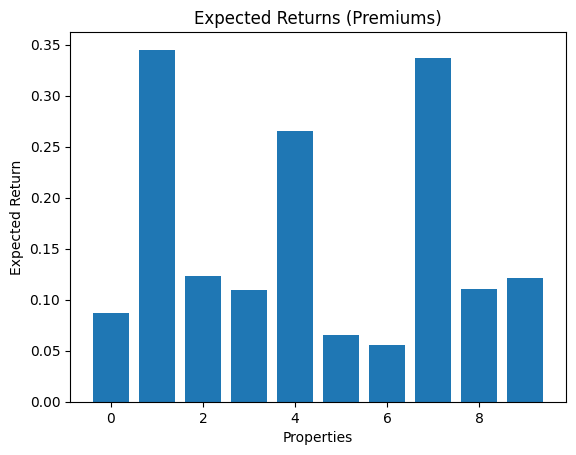

In [8]:
# Plot mu as bar chart
plt.bar(range(n_properties), mu)
plt.title("Expected Returns (Premiums)")
plt.xlabel("Properties")
plt.ylabel("Expected Return")
plt.show()

# try 1


In [9]:
# Parameters
from pyqubo import Binary

q = 0.05
lambda_val = 30
n =10  # Number of properties
B = 3

x = [Binary(f'x_{i}') for i in range(n)]
risk_term = 0
for i in range(n):
    for j in range(n):
        risk_term += sigma[i, j] * x[i] * x[j]

risk_term = risk_term * q

reward = 0
for i in range(n):
    reward -= mu[i] * x[i]

penatly = 0
for i in range(n):
    penatly += x[i] 

penalty = lambda_val * (penatly - B)**2

H = reward - risk_term + penalty



model = H.compile()

qubo, offset = model.to_qubo()

from qiskit_optimization import QuadraticProgram
qp = QuadraticProgram()

# Add binary variables (Assuming our variables are named 'x_0', 'x_1', ... 'x_9')
for i in range(n):
    qp.binary_var(name=f'x_{i}')

# Prepare dictionaries for the linear and quadratic terms
linear = {}
quadratic = {}
for key, coeff in qubo.items():
    if len(key) == 1:
        var_name = key[0]  # e.g., 'x_0'
        linear[var_name] = coeff
    elif len(key) == 2:
        var1, var2 = key  # e.g., 'x_0', 'x_1'
        quadratic[(var1, var2)] = coeff

qp.minimize(linear=linear, quadratic=quadratic)

# Now, printing qp should show the variables and the objective
print(qp)



minimize -150.08783642209448*x_0^2 + 59.99922087871064*x_0*x_1 + 59.99941388044578*x_0*x_2 + 59.99958354395654*x_0*x_3 + 59.99950027168565*x_0*x_4 + 59.99973770262723*x_0*x_5 + 59.99975223367084*x_0*x_6 + 59.999297048422456*x_0*x_7 + 59.99956170076333*x_0*x_8 + 59.99954330771751*x_0*x_9 - 150.3510251452532*x_1^2 + 59.99937818160419*x_1*x_2 + 59.99929426151633*x_1*x_3 + 59.99795506658832*x_1*x_4 + 59.9995344747865*x_1*x_5 + 59.99973069996035*x_1*x_6 + 59.997517103693795*x_1*x_7 + 59.999123933987676*x_1*x_8 + 59.999298463565495*x_1*x_9 - 150.12395829871747*x_2^2 + 59.999325493625776*x_2*x_3 + 59.99904938336949*x_2*x_4 + 59.99954441731642*x_2*x_5 + 59.99970365418087*x_2*x_6 + 59.99940755644648*x_2*x_7 + 59.99926134680358*x_2*x_8 + 59.999292368390385*x_2*x_9 - 150.11046937365214*x_3^2 + 59.9993715650159*x_3*x_4 + 59.999638253807156*x_3*x_5 + 59.999685630855446*x_3*x_6 + 59.99941433094589*x_3*x_7 + 59.99938206154714*x_3*x_8 + 59.9993770608355*x_3*x_9 - 150.26912908155344*x_4^2 + 59.99961619

In [10]:
def create_quadratic_program(sigma, mu, q=0.05, lambda_val=30, n=10, B=3):

    

    # Define binary decision variables
    x = [Binary(f'x_{i}') for i in range(n)]
    
    # Build risk term using the covariance matrix.
    risk_term = 0
    for i in range(n):
        for j in range(n):
            risk_term +=  sigma[i, j] * x[i] * x[j]
    risk_term = risk_term * q  

    reward = 0
    for i in range(n):
        reward -= mu[i] * x[i]

    # Build penalty term to enforce the constraint on the number of selected assets.
    penalty_sum = sum(x[i] for i in range(n))
    penalty = lambda_val * (penalty_sum - B) ** 2

    # Total Hamiltonian (objective function)
    H = reward - risk_term + penalty

    # Compile the model and obtain the QUBO formulation.
    model = H.compile()
    qubo, _ = model.to_qubo()  # The computed offset is ignored.
    offset = 0  # Force the offset to be 0

    # Create the Qiskit quadratic program.
    qp = QuadraticProgram()

    # Add binary variables (named x_0, x_1, ..., x_{n-1}).
    for i in range(n):
        qp.binary_var(name=f'x_{i}')

    # Prepare dictionaries for the linear and quadratic terms.
    linear = {}
    quadratic = {}
    for key, coeff in qubo.items():
        if len(key) == 1:
            var_name = key[0]
            linear[var_name] = coeff
        elif len(key) == 2:
            var1, var2 = key
            quadratic[(var1, var2)] = coeff

    qp.minimize(linear=linear, quadratic=quadratic)
    
    return qp

In [11]:
print(x[4])
print(risk_term)
print(mu)

Binary('x_4')
((((0.014594 * Binary('x_9')) * Binary('x_9')) + ((0.005769 * Binary('x_9')) * Binary('x_8')) + ((0.009059 * Binary('x_9')) * Binary('x_7')) + ((0.003052 * Binary('x_9')) * Binary('x_6')) + ((0.004150 * Binary('x_9')) * Binary('x_5')) + ((0.007165 * Binary('x_9')) * Binary('x_4')) + ((0.006229 * Binary('x_9')) * Binary('x_3')) + ((0.007076 * Binary('x_9')) * Binary('x_2')) + ((0.007015 * Binary('x_9')) * Binary('x_1')) + ((0.004567 * Binary('x_9')) * Binary('x_0')) + ((0.005769 * Binary('x_8')) * Binary('x_9')) + ((0.012125 * Binary('x_8')) * Binary('x_8')) + ((0.008580 * Binary('x_8')) * Binary('x_7')) + ((0.003000 * Binary('x_8')) * Binary('x_6')) + ((0.003300 * Binary('x_8')) * Binary('x_5')) + ((0.005312 * Binary('x_8')) * Binary('x_4')) + ((0.006179 * Binary('x_8')) * Binary('x_3')) + ((0.007387 * Binary('x_8')) * Binary('x_2')) + ((0.008761 * Binary('x_8')) * Binary('x_1')) + ((0.004383 * Binary('x_8')) * Binary('x_0')) + ((0.009059 * Binary('x_7')) * Binary('x_9'))

In [140]:
print(qp.prettyprint())

Problem name: 

Minimize
  -150.08783642209448*x_0^2 + 59.99922087871064*x_0*x_1
  + 59.99941388044578*x_0*x_2 + 59.99958354395654*x_0*x_3
  + 59.99950027168565*x_0*x_4 + 59.99973770262723*x_0*x_5
  + 59.99975223367084*x_0*x_6 + 59.999297048422456*x_0*x_7
  + 59.99956170076333*x_0*x_8 + 59.99954330771751*x_0*x_9
  - 150.3510251452532*x_1^2 + 59.99937818160419*x_1*x_2
  + 59.99929426151633*x_1*x_3 + 59.99795506658832*x_1*x_4
  + 59.9995344747865*x_1*x_5 + 59.99973069996035*x_1*x_6
  + 59.997517103693795*x_1*x_7 + 59.999123933987676*x_1*x_8
  + 59.999298463565495*x_1*x_9 - 150.12395829871747*x_2^2
  + 59.999325493625776*x_2*x_3 + 59.99904938336949*x_2*x_4
  + 59.99954441731642*x_2*x_5 + 59.99970365418087*x_2*x_6
  + 59.99940755644648*x_2*x_7 + 59.99926134680358*x_2*x_8
  + 59.999292368390385*x_2*x_9 - 150.11046937365214*x_3^2
  + 59.9993715650159*x_3*x_4 + 59.999638253807156*x_3*x_5
  + 59.999685630855446*x_3*x_6 + 59.99941433094589*x_3*x_7
  + 59.99938206154714*x_3*x_8 + 59.999377060835

In [ ]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        # Use global mu, sigma, q, gamma, lambda_val, B
        reward = -np.sum(mu * x)
        risk = q * np.sum(x[:, None] * x[None, :] * sigma)
        penalty = lambda_val * (np.sum(x) - B) ** 2
        value = reward + risk + penalty
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

: 

In [12]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="pairwise")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

/var/folders/4m/ybdr7r2j2_nbh1ytdjdqr5v00000gn/T/ipykernel_73878/4035947797.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)


NameError: name 'print_result' is not defined

In [ ]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.], value -270.9683

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1 0 0 1 0 0]	-0.9263		1.0000


In [13]:
def print_result(result, qp):
    """
    Print final and intermediate results
    """

    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = qp.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))


def get_result_numpy(qp, penalty=None):
    """
    Get the result using the exact, classical eigensolver NumPyMinimumEigensolver.
    Return: MinimumEigenOptimizationResult
    """

    exact_mes = NumPyMinimumEigensolver()
    exact_eigensolver = MinimumEigenOptimizer(exact_mes, penalty=penalty)
    result = exact_eigensolver.solve(qp)

    return result

# Configure a fully parameterized TwoLocal ansatz

def get_result_SamplingVQE(
        qp,
        ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=['rx', 'y'], entanglement='linear', reps=2),
        optimizer=COBYLA(),
        sampler=Sampler(),
        penalty=None
):
    """
    Get the result using as model SamplingVQE(sampler, ansatz, optimizer).
    Return: MinimumEigenOptimizationResult
    """

    # List to store the cost history
    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Define the callback function to capture the cost value at each iteration
    def store_cost(eval_count, params, value, meta):
        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(value.real)
        cost_history_dict["meta"].append(meta)

    svqe_mes = SamplingVQE(ansatz=ansatz, optimizer=optimizer,
                           sampler=sampler, callback=store_cost)
    svqe = MinimumEigenOptimizer(svqe_mes, penalty=penalty)
    result = svqe.solve(qp)

    return result, cost_history_dict


def get_result_QAOA(
    qp,
    optimizer=COBYLA(),
    reps = 1
):
    
    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Define the callback function to capture the cost value at each iteration
    def store_cost(eval_count, params, value, meta):
        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(value.real)
        cost_history_dict["meta"].append(meta)


    qaoa_mes = QAOA(sampler = Sampler(), optimizer=optimizer, reps=reps, callback= store_cost)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)

    return result, cost_history_dict


def get_result_wrapper(result_function, **kwargs):
    """
    Wrapper function to call either get_result_QAOA or get_result_SamplingVQE
    with the provided keyword arguments.
    
    Parameters:
    - result_function: The function to call (get_result_QAOA or get_result_SamplingVQE)
    - kwargs: The keyword arguments to pass to the function
    
    Returns:
    - result: The result from the called function
    - cost_history_dict: The cost history dictionary from the called function
    """

    result, cost_history_dict = result_function(**kwargs)
    
    return result, cost_history_dict


def plot_result_histogram(result, threshold=0):
    """
    Plot the histogram of the valid samples.
    """
    
    # Filter the samples with OptimizationResultStatus.SUCCESS and value below threshold
    valid_samples = []
    for s in result.samples:
        if s.status == OptimizationResultStatus.SUCCESS and s.probability > threshold:
            valid_samples.append(s)

    # Create samples dictionary
    samples_for_plot = {
        " ".join(f"{int(v)}" for i, v in enumerate(s.x)): s.probability
        for s in valid_samples
    }

    # Plot histogram
    fig = plot_histogram(samples_for_plot)
    return fig


def plot_cost_history(cost_history_dict, reference=None):
    """
    Plot the cost history.
    """

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(cost_history_dict["cost"], lw=2, marker="o")
    if reference is not None:
        ax.axhline(reference, color="red", ls="--")
    ax.set_ylabel("Cost", fontsize=14)
    ax.set_xlabel("Evaluation count", fontsize=14)
    ax.set_title("Cost history", fontsize=14)
    
    return fig

def prob_exact(result_svqe, result_exact):
    """"
    Find the probability of the exact optimal solution in the SamplingVQE result.
    """
    exact_x = result_exact.x
    prob_vqe = 0
    for sample in result_svqe.samples:
        if sample.x.all() == exact_x.all():
            prob_vqe = sample.probability
            break

    return prob_vqe

/var/folders/4m/ybdr7r2j2_nbh1ytdjdqr5v00000gn/T/ipykernel_73878/2415085015.py:45: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler(),


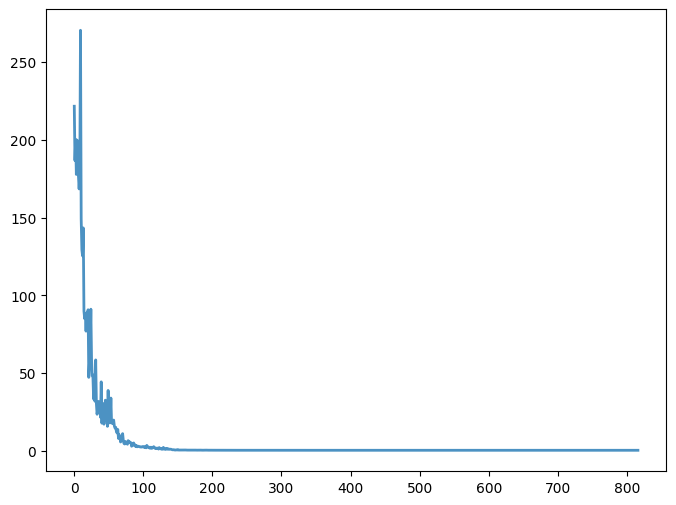

In [ ]:
# Parameters

rotation_blocks=["rx", "y"]
entanglement_blocks="ecr"
entanglement="full"
reps = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

reference_fval = np.array([])
prob_vqe_exact = []
error_vqe_cost = []
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = np.append(reference_fval, result_exact.fval)

# SamplingVQE result
# ansatz = EfficientSU2(num_qubits=q, reps=reps, su2_gates=su2_gates, entanglement=entanglement)
ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, 
                    entanglement=entanglement, reps=reps, entanglement_blocks=entanglement_blocks)

result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

# Function values and probabilities
fvals = np.array([s.fval for s in result_svqe.samples])
probabilities = np.array([s.probability for s in result_svqe.samples])

prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)


ax.plot(history["cost"] - reference_cost, lw=2, alpha=0.8, label=f"{q}")

## Sweep the SU2 gates


Starting entanglement  full ,  1  layers
Starting entanglement  full ,  2  layers
Starting entanglement  full ,  3  layers
Starting entanglement  full ,  4  layers
Starting entanglement  full ,  5  layers
Starting entanglement  full ,  6  layers
Starting entanglement  full ,  7  layers
Starting entanglement  full ,  15  layers


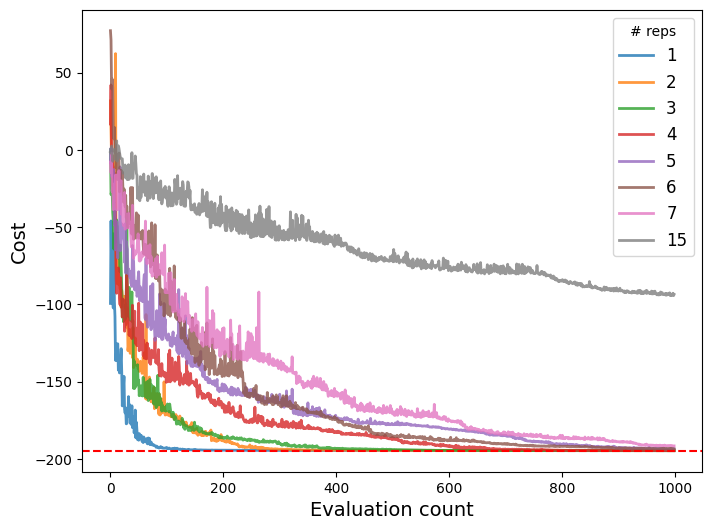

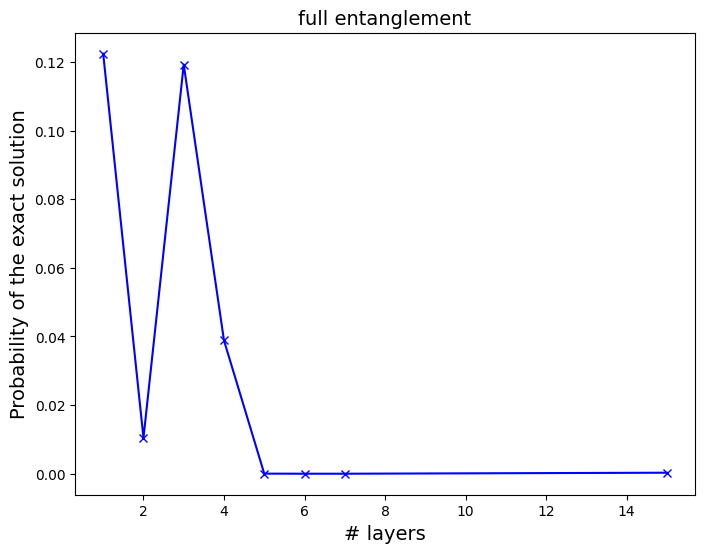

In [ ]:
# Sweep number of layers

reps_sweep = [1, 2, 3, 4, 5, 6, 7, 15]
save_folder = r"/Users/romantudorgeorge/Desktop"

# Parameters
rotation_blocks=["rx", "y"]
entanglement_blocks="ecr"
entanglement="full"

# Data
qp = create_quadratic_program(sigma=sigma, mu=mu)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Sweep
prob_vqe_exact = []
error_vqe_cost = []

for reps in reps_sweep:

    print('Starting entanglement ', entanglement, ', ', reps, ' layers')

    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, reps=reps, entanglement_blocks=entanglement_blocks)
    # ansatz = EfficientSU2(num_qubits=num_assets, su2_gates=su2_gates, entanglement=entanglement, reps=reps)
    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

    # Function values and probabilities
    fvals = np.array([s.fval for s in result_svqe.samples])
    probabilities = np.array([s.probability for s in result_svqe.samples])

    # Compute statistics of the results
    prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
    error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)

    ax.plot(history["cost"], lw=2, alpha=0.8, label=f"{reps}")

# Complete the cost plot
ax.axhline(reference_cost, color="red", ls="--")
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="# reps", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()

# Plot the probability of the exact solution as a function of the error in the cost function value (compared to the exact solution)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(reps_sweep, prob_vqe_exact, marker="x", color="blue")
ax.set_ylabel("Probability of the exact solution", fontsize=14)
ax.set_xlabel("# layers", fontsize=14)
ax.set_title(entanglement + r" entanglement", fontsize=14)
fig.savefig(save_folder + entanglement + r"_" + str(reps) + r"rep_prob.png")

['rx', 'y']
['ry', 'x']
['y', 'rx']
['x', 'ry']
['rx', 'ry']
['ry', 'rx']


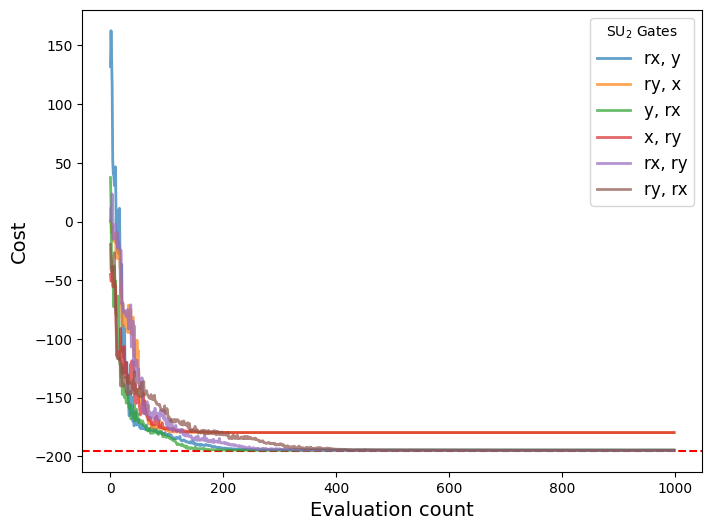

In [ ]:
num_assets = 10
save_folder = r"/Users/romantudorgeorge/Desktop"

# Parameters
rotation_blocks_sweep=[["rx", "y"], ["ry", "x"], ["y", "rx"], ["x", "ry"], ["rx", "ry"], ["ry", "rx"]]
entanglement="full"
reps = 1
entanglement_blocks="ecr"

# Data
qp = create_quadratic_program(sigma=sigma, mu=mu)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.axhline(reference_cost, color="red", ls="--")

# Sweep
for rotation_blocks in rotation_blocks_sweep:

    print(rotation_blocks)

    # ansatz = EfficientSU2(num_qubits=num_assets, su2_gates=su2_gates, entanglement=entanglement, reps=reps)
    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, reps=reps,
                      entanglement_blocks=entanglement_blocks)

    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

    # Function values and probabilities
    fvals = np.array([s.fval for s in result_svqe.samples])
    probabilities = np.array([s.probability for s in result_svqe.samples])

    # Compute statistics of the results
    ax.plot(history["cost"], lw=2, alpha=0.7, label=rotation_blocks[0] + r", " + rotation_blocks[1])

# Complete the cost plot
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="SU$_2$ Gates", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()


# fetch data


In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('us_disaster_declarations.csv')

# Convert the date column to datetime.
# (Assuming that the relevant date column is called 'declaration_date'. If the file has a different column name for the date, change it accordingly.)
df['declaration_date'] = pd.to_datetime(df['declaration_date'], errors='coerce')

# Choose a two-year period between 2011 and 2013.
# For example, here we choose 2011 and 2012.
years_chosen = [2011, 2012]
df_period = df[df['declaration_date'].dt.year.isin(years_chosen)]

# Specify 10 states to filter. (Adjust these state abbreviations if needed.)
states_chosen = ["TX", "CA", "FL", "NY", "IL", "NC", "GA", "AZ", "PA", "TN"]
df_filtered = df_period[df_period['state'].isin(states_chosen)]

# Group by state and count the number of disasters.
state_counts = df_filtered.groupby('state').size().reset_index(name='raw_count')

# Normalize the counts between 0 and 1.
# Normalization: (value - min) / (max - min). Ensure we handle a potential division by zero.
min_count = state_counts['raw_count'].min()
max_count = state_counts['raw_count'].max()

if max_count == min_count:
    # If all states have the same raw count, set normalized value to 1 (or any constant value)
    state_counts['normalized'] = 1.0
else:
    state_counts['normalized'] = (state_counts['raw_count'] - min_count) / (max_count - min_count)

# Print the results: each row shows the state, the raw disaster count, and the normalized number.
print(state_counts)
normalized_disasters = state_counts['normalized'].to_numpy()

print(normalized_disasters)


  state  raw_count  normalized
0    AZ          4    0.000000
1    CA         22    0.069767
2    FL         47    0.166667
3    GA         32    0.108527
4    IL         86    0.317829
5    NC         94    0.348837
6    NY        188    0.713178
7    PA        176    0.666667
8    TN        113    0.422481
9    TX        262    1.000000
[0.         0.06976744 0.16666667 0.10852713 0.31782946 0.34883721
 0.71317829 0.66666667 0.42248062 1.        ]


In [ ]:

df = pd.read_csv("US_violent_crime.csv", index_col=0)  

states_chosen = ["Texas", "California", "Florida", "New York", "Illinois",
                 "North Carolina", "Georgia", "Arizona", "Pennsylvania", "Tennessee"]

filtered_df = df.loc[states_chosen, ['Murder', 'Assault', 'Rape']]

mean_per_state = filtered_df.mean(axis=1)
mean_per_crime = filtered_df.mean(axis=0)

print("Mean of crimes (Murder, Assault, Rape) for each selected state:")
print(mean_per_state)
print("\nMean of each crime type across selected states:")
print(mean_per_crime)

print("\n--- Normalizing the means to be between 0 and 1 ---")

min_state_mean = mean_per_state.min()
max_state_mean = mean_per_state.max()

normalized_state_mean = (mean_per_state - min_state_mean) / (max_state_mean - min_state_mean)

print("\nNormalized mean of crimes for each selected state (between 0 and 1):")
print(normalized_state_mean)

# Normalize the mean for each crime type
min_crime_mean = mean_per_crime.min()
max_crime_mean = mean_per_crime.max()

normalized_crime_mean = (mean_per_crime - min_crime_mean) / (max_crime_mean - min_crime_mean)

print("\nNormalized mean of each crime type across selected states (between 0 and 1):")
print(normalized_crime_mean)

normalized_crime_array = normalized_state_mean.to_numpy()

print("\nArray of normalized mean for each crime type:")
print(normalized_crime_array)

Mean of crimes (Murder, Assault, Rape) for each selected state:
Texas              79.733333
California        108.533333
Florida           127.433333
New York           97.066667
Illinois           94.466667
North Carolina    122.033333
Georgia            84.733333
Arizona           111.033333
Pennsylvania       42.400000
Tennessee          76.033333
dtype: float64

Mean of each crime type across selected states:
Murder      11.66
Assault    245.10
Rape        26.28
dtype: float64

--- Normalizing the means to be between 0 and 1 ---

Normalized mean of crimes for each selected state (between 0 and 1):
Texas             0.439044
California        0.777734
Florida           1.000000
New York          0.642885
Illinois          0.612309
North Carolina    0.936495
Georgia           0.497844
Arizona           0.807134
Pennsylvania      0.000000
Tennessee         0.395531
dtype: float64

Normalized mean of each crime type across selected states (between 0 and 1):
Murder     0.000000
Assault

In [ ]:
average_wood_price = 370.00 # maybe it s not usefull

μ 
adjusted =μ−0.1⋅crime_rates−0.1⋅disaster_rates

In [ ]:
mu_a = np.empty_like(mu)
w1 = 0.032
for i in range(n_properties):
    mu_a[i] = mu[i] - (w1 * normalized_crime_array[i] + w1 * normalized_crime_array[i])

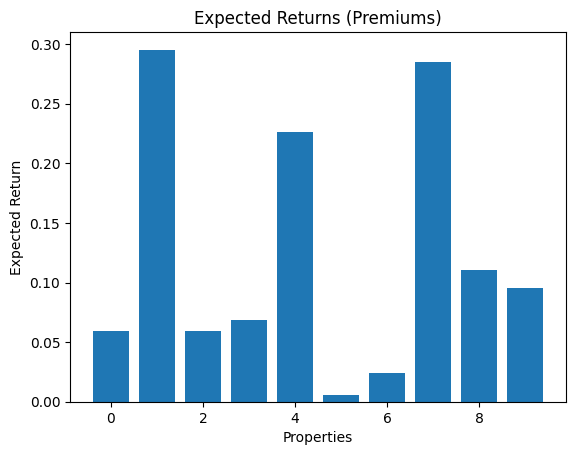

In [ ]:
plt.bar(range(n_properties), mu_a)
plt.title("Expected Returns (Premiums)")
plt.xlabel("Properties")
plt.ylabel("Expected Return")
plt.show()

# run again with new qp

In [ ]:
qp1 = create_quadratic_program(sigma=sigma, mu= mu_a)
qa  = create_quadratic_program( sigma=sigma, mu = mu)


rotation_blocks=["rx", "y"]

ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, 
                    entanglement=entanglement, reps=reps, entanglement_blocks=entanglement_blocks)





result_svqe1, history1 = get_result_SamplingVQE(qp1, ansatz=ansatz)

result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)



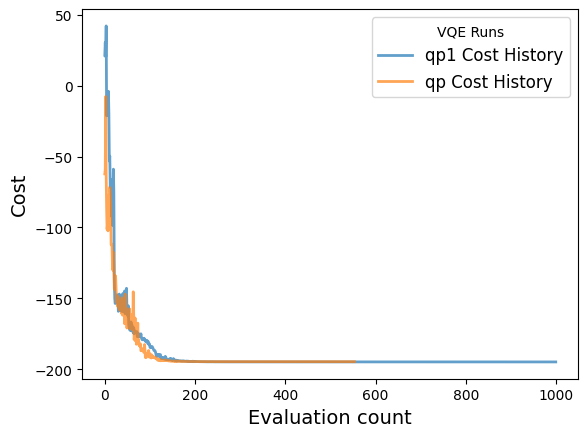

In [ ]:
fig, ax = plt.subplots()

# Plot the cost history for qp1 (first VQE result)
ax.plot(history1["cost"], lw=2, alpha=0.7, label="qp1 Cost History")

# Plot the cost history for qp (second VQE result)
ax.plot(history["cost"], lw=2, alpha=0.7, label="qp Cost History")

# Label the axes
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)

# Add a legend with a title if needed
ax.legend(title="VQE Runs", fontsize=12)

# Save the figure to the specified folder
fig.savefig(save_folder + "cost_history.png")

# Display the plot
plt.show()

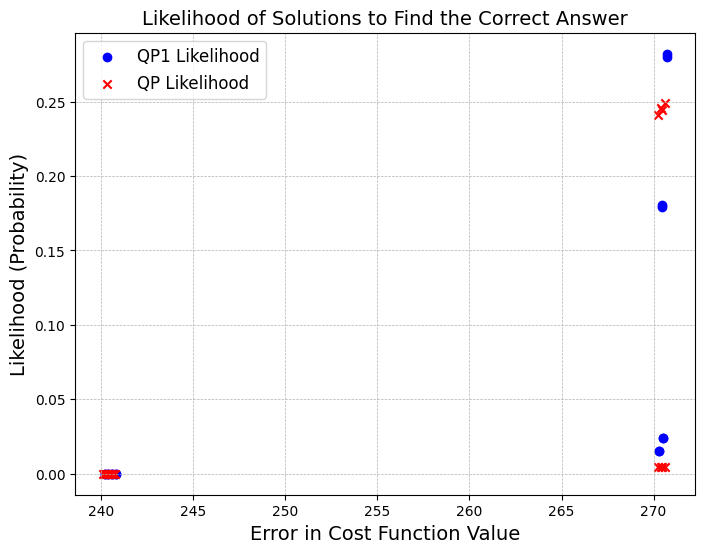

Starting entanglement  full ,  1  layers
Trial 1 of 5 for 1 layers
Trial 2 of 5 for 1 layers
Trial 3 of 5 for 1 layers
Trial 4 of 5 for 1 layers
Trial 5 of 5 for 1 layers
Starting entanglement  full ,  2  layers
Trial 1 of 5 for 2 layers
Trial 2 of 5 for 2 layers
Trial 3 of 5 for 2 layers
Trial 4 of 5 for 2 layers
Trial 5 of 5 for 2 layers
Starting entanglement  full ,  3  layers
Trial 1 of 5 for 3 layers
Trial 2 of 5 for 3 layers
Trial 3 of 5 for 3 layers
Trial 4 of 5 for 3 layers
Trial 5 of 5 for 3 layers
Starting entanglement  full ,  4  layers
Trial 1 of 5 for 4 layers
Trial 2 of 5 for 4 layers
Trial 3 of 5 for 4 layers
Trial 4 of 5 for 4 layers
Trial 5 of 5 for 4 layers
Starting entanglement  full ,  5  layers
Trial 1 of 5 for 5 layers
Trial 2 of 5 for 5 layers
Trial 3 of 5 for 5 layers
Trial 4 of 5 for 5 layers
Trial 5 of 5 for 5 layers
Starting entanglement  full ,  6  layers
Trial 1 of 5 for 6 layers
Trial 2 of 5 for 6 layers
Trial 3 of 5 for 6 layers
Trial 4 of 5 for 6 layers


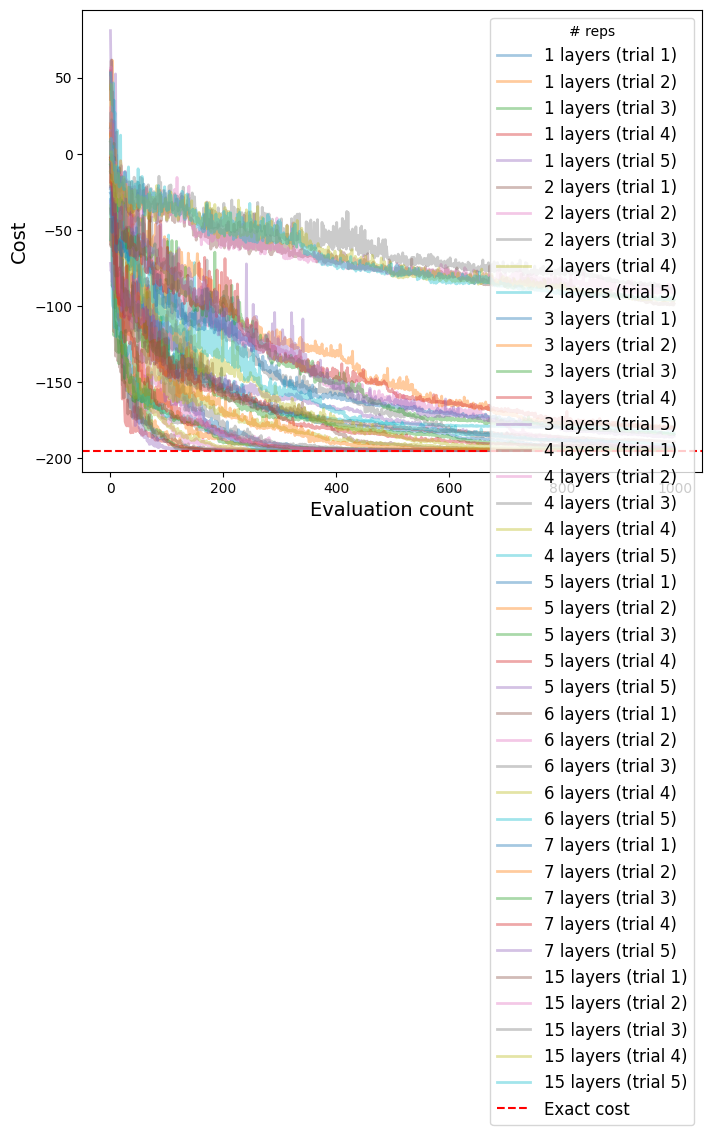

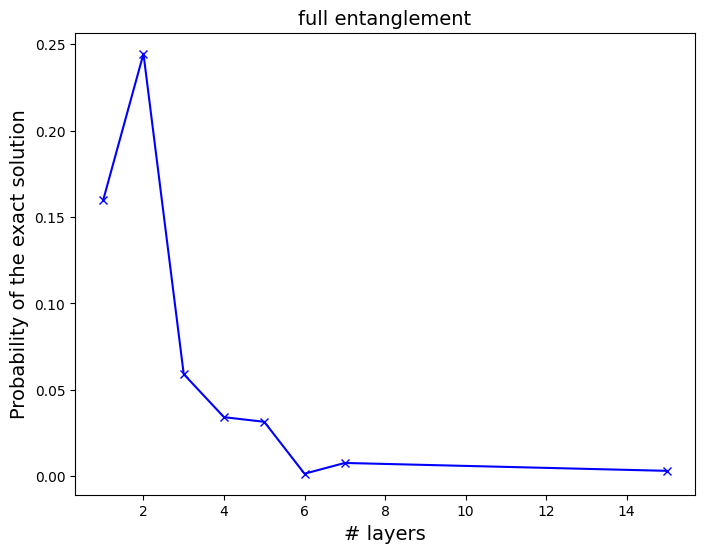

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

reps_sweep = [1, 2, 3, 4, 5, 6, 7, 15]
save_folder = r"/Users/romantudorgeorge/Desktop"

# Parameters
rotation_blocks = ["rx", "y"]
entanglement_blocks = "ecr"
entanglement = "full"

# Data
qp = create_quadratic_program(sigma=sigma, mu=mu)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Number of repetitions per layer value
n_trials = 5

# Containers for averaged results
mean_prob_vqe_exact = []
mean_error_vqe_cost = []

# For plotting individual cost history curves (optional)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Sweep over the number of layers
for reps in reps_sweep:
    trial_probs = []
    trial_errors = []
    
    print('Starting entanglement ', entanglement, ', ', reps, ' layers')
    
    # Optionally, you can average the cost history too, but here we only save one of them for illustration.
    for trial in range(n_trials):
        print(f"Trial {trial+1} of {n_trials} for {reps} layers")
        ansatz = TwoLocal(num_qubits=num_assets,
                           rotation_blocks=rotation_blocks, 
                           entanglement=entanglement, 
                           reps=reps, 
                           entanglement_blocks=entanglement_blocks)
        # Run the VQE routine
        result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)
        
        # Function values and probabilities (if needed for further analysis)
        fvals = np.array([s.fval for s in result_svqe.samples])
        probabilities = np.array([s.probability for s in result_svqe.samples])
            
        # Compute and store the statistics for this trial
        trial_prob = prob_exact(result_svqe, result_exact)
        trial_error = result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost
        
        trial_probs.append(trial_prob)
        trial_errors.append(trial_error)
        
        # Plot the cost history for this trial (optional)
        ax.plot(history["cost"], lw=2, alpha=0.4, label=f"{reps} layers (trial {trial+1})")
    
    # Average over trials for the current number of layers
    mean_prob = np.mean(trial_probs)
    mean_error = np.mean(trial_errors)
    
    mean_prob_vqe_exact.append(mean_prob)
    mean_error_vqe_cost.append(mean_error)

# Complete the cost plot
ax.axhline(reference_cost, color="red", ls="--", label="Exact cost")
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="# reps", fontsize=12)
fig.savefig(save_folder + "/cost_history.png")
plt.show()

# Plot the probability of the exact solution (averaged over trials) as a function of the number of layers
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(reps_sweep, mean_prob_vqe_exact, marker="x", color="blue")
ax.set_ylabel("Probability of the exact solution", fontsize=14)
ax.set_xlabel("# layers", fontsize=14)
ax.set_title(entanglement + r" entanglement", fontsize=14)
fig.savefig(save_folder + "/" + entanglement + r"_rep_prob.png")
plt.show()


In [ ]:
max_length = max(len(h) for h in cost_histories)
    padded_histories = [np.pad(h, (0, max_length - len(h)), mode='edge') for h in cost_histories]
    mean_cost_history = np.mean(padded_histories, axis=0)
    mean_cost_histories[reps] = mean_cost_history
    
    # Plot the mean cost history for this reps
    ax.plot(mean_cost_history, lw=2, label=f"{reps} layers")

# Complete the cost plot
ax.axhline(reference_cost, color="red", ls="--", label="Exact cost")
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="# reps", fontsize=12)
fig.savefig(save_folder + "/mean_cost_history.png")
plt.show()

IndentationError: unexpected indent (30436335.py, line 2)

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate



def A_gate(theta, phi):
    """Construct the A(θ,ϕ) gate matrix in the computational basis [|00>,|01>,|10>,|11>]."""
    cos = np.cos(theta)
    sin = np.sin(theta)
    e_iphi = np.exp(1j * phi)
    e_minus_iphi = np.exp(-1j * phi)
    
    # Define the 4x4 matrix for A(θ,ϕ)
    matrix = np.array([
        [1,        0,              0,         0],
        [0,      cos,      e_iphi * sin,         0],
        [0, e_minus_iphi * sin,     -cos,         0],
        [0,        0,              0,         1]
    ], dtype=complex)
    return matrix

# Example parameters
theta = np.pi / 4  # adjust as needed
phi = np.pi / 2    # adjust as needed

# Create the unitary matrix for the gate
matrix = A_gate(theta, phi)

# Create a custom UnitaryGate
A_custom = UnitaryGate(matrix, label="A(θ,ϕ)")

# Build a quantum circuit with 2 qubits and append the custom gate
qc = QuantumCircuit(2)
qc.append(A_custom, [0, 1])

# To visualize the circuit (requires matplotlib)
print(qc.draw(output='text'))


     ┌─────────┐
q_0: ┤0        ├
     │  A(θ,ϕ) │
q_1: ┤1        ├
     └─────────┘


In [ ]:
import numpy as np
from qiskit import QuantumCircuit

def subscript(num):
    """Convert an integer to a Unicode subscript string."""
    subscripts = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    return str(num).translate(subscripts)

def A_gate(theta, phi):
    """Construct the A(θ,ϕ) gate matrix in the computational basis [|00>, |01>, |10>, |11>]."""
    cos = np.cos(theta)
    sin = np.sin(theta)
    e_iphi = np.exp(1j * phi)
    e_minus_iphi = np.exp(-1j * phi)
    matrix = np.array([
        [1,          0,               0,         0],
        [0,        cos,       e_iphi * sin,       0],
        [0, e_minus_iphi * sin,      -cos,           0],
        [0,          0,               0,         1]
    ], dtype=complex)
    return matrix

def build_ansatz_circuit():
    # ---- Existing layers ----
    # Define unique parameter sets for the first layer (5 gates)
    params_first_layer = [
        (np.pi/4, np.pi/2),
        (np.pi/5, np.pi/3),
        (np.pi/6, np.pi/4),
        (np.pi/7, np.pi/8),
        (np.pi/8, np.pi/9)
    ]

    # Define unique parameter sets for the second layer (4 gates)
    params_second_layer = [
        (np.pi/10, np.pi/11),
        (np.pi/12, np.pi/13),
        (np.pi/14, np.pi/15),
        (np.pi/16, np.pi/17)
    ]

    # Create a 10-qubit circuit (indices 0 to 9)
    qc = QuantumCircuit(10)
    qc.x(1)
    qc.x(3)
    qc.x(9)
    qc.barrier()

    # Global counter for labeling gates
    counter = 1

    # First layer: apply gate on pairs [0,1], [2,3], [4,5], [6,7], [8,9]
    pairs_first_layer = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
    for (q1, q2), (theta, phi) in zip(pairs_first_layer, params_first_layer):
        matrix = A_gate(theta, phi)
        label = f"A(θ{subscript(counter)},ϕ{subscript(counter)})"
        qc.unitary(matrix, [q1, q2], label=label)
        counter += 1

    # Second layer: apply gate on pairs [1,2], [3,4], [5,6], [7,8]
    pairs_second_layer = [(1, 2), (3, 4), (5, 6), (7, 8)]
    for (q1, q2), (theta, phi) in zip(pairs_second_layer, params_second_layer):
        matrix = A_gate(theta, phi)
        label = f"A(θ{subscript(counter)},ϕ{subscript(counter)})"
        qc.unitary(matrix, [q1, q2], label=label)
        counter += 1

    # ---- Additional extra gates ----
    # Extra gates on pairs [0,1], [2,3], and [3,4]
    # Using five new parameters:
    #   - Gate on [0,1]: use new parameters (θ₆, ϕ₆)
    #   - Gate on [2,3]: use new parameters (θ₇, ϕ₇)
    #   - Gate on [3,4]: use new parameter θ₈ and re-use ϕ₆ from the first extra gate.
    extra_pairs = [(0, 1), (2, 3), (3, 4)]
    theta_extra1, phi_extra1 = np.pi/9, np.pi/10   # Gate on [0,1]
    theta_extra2, phi_extra2 = np.pi/11, np.pi/12   # Gate on [2,3]
    theta_extra3 = np.pi/13                         # Gate on [3,4]; reusing phi_extra1
    
    # Apply extra gate on [0,1]
    matrix = A_gate(theta_extra1, phi_extra1)
    label = f"A(θ{subscript(counter)},ϕ{subscript(counter)})"
    qc.unitary(matrix, extra_pairs[0], label=label)
    counter += 1

    # Apply extra gate on [2,3]
    matrix = A_gate(theta_extra2, phi_extra2)
    label = f"A(θ{subscript(counter)},ϕ{subscript(counter)})"
    qc.unitary(matrix, extra_pairs[1], label=label)
    counter += 1

    # Apply extra gate on [3,4] using new θ and reusing ϕ from the first extra gate (ϕ₆)
    matrix = A_gate(theta_extra3, phi_extra1)
    label = f"A(θ{subscript(counter)},ϕ{subscript(counter-2)})"  # Reuse phi from extra gate on [0,1]
    qc.unitary(matrix, (1, 2), label=label)
    counter += 1

    return qc

# Build the circuit and print it
circuit = build_ansatz_circuit()
print(circuit.draw(output='text'))


           ░ ┌───────────┐             ┌─────────────┐               
q_0: ──────░─┤0          ├─────────────┤0            ├───────────────
     ┌───┐ ░ │  A(θ₁,ϕ₁) │┌───────────┐│  A(θ₁₀,ϕ₁₀) │┌─────────────┐
q_1: ┤ X ├─░─┤1          ├┤0          ├┤1            ├┤0            ├
     └───┘ ░ ├───────────┤│  A(θ₆,ϕ₆) │├─────────────┤│  A(θ₁₂,ϕ₁₀) │
q_2: ──────░─┤0          ├┤1          ├┤0            ├┤1            ├
     ┌───┐ ░ │  A(θ₂,ϕ₂) │├───────────┤│  A(θ₁₁,ϕ₁₁) │└─────────────┘
q_3: ┤ X ├─░─┤1          ├┤0          ├┤1            ├───────────────
     └───┘ ░ ├───────────┤│  A(θ₇,ϕ₇) │└─────────────┘               
q_4: ──────░─┤0          ├┤1          ├──────────────────────────────
           ░ │  A(θ₃,ϕ₃) │├───────────┤                              
q_5: ──────░─┤1          ├┤0          ├──────────────────────────────
           ░ ├───────────┤│  A(θ₈,ϕ₈) │                              
q_6: ──────░─┤0          ├┤1          ├──────────────────────────────
           ░ │  A(θ₄

In [23]:
# Build and display the circuit
ansatz = build_parametrized_ansatz1()
print(ansatz.draw(output='text'))

IndexError: list index out of range

TypeError: ParameterExpression with unbound parameters (dict_keys([Parameter(θ₁)])) cannot be cast to a complex.

In [24]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

def R_gate_circuit(theta, phi):
    """Implements R(θ, ϕ) = Rz(ϕ + π) Ry(θ + π/2) on a single qubit."""
    qc = QuantumCircuit(1)
    qc.ry(theta + np.pi/2, 0)  # Ry(θ + π/2)
    qc.rz(phi + np.pi, 0)      # Rz(ϕ + π)
    return qc

def R_gate_dagger_circuit(theta, phi):
    """Implements R(θ, ϕ)† = Ry(-(θ + π/2)) Rz(-(ϕ + π)) on a single qubit."""
    qc = QuantumCircuit(1)
    qc.rz(-(phi + np.pi), 0)   # Rz(-(ϕ + π))
    qc.ry(-(theta + np.pi/2), 0)  # Ry(-(θ + π/2))
    return qc

def A_gate_circuit(theta, phi):
    """Implements A(θ, ϕ) using the decomposition: CNOT R(θ, ϕ) CNOT R(θ, ϕ)† CNOT."""
    qc = QuantumCircuit(2)
    # First CNOT (control: qubit 0, target: qubit 1)
    qc.cx(0, 1)
    # R(θ, ϕ) on qubit 1
    r_gate = R_gate_circuit(theta, phi)
    qc.append(r_gate, [1])
    # Second CNOT
    qc.cx(0, 1)
    # R(θ, ϕ)† on qubit 1
    r_dagger_gate = R_gate_dagger_circuit(theta, phi)
    qc.append(r_dagger_gate, [1])
    # Third CNOT
    qc.cx(0, 1)
    return qc

In [28]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def subscript(num):
    """Convert an integer to a Unicode subscript string."""
    subscripts = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    return str(num).translate(subscripts)

# Placeholder for A_gate_circuit (since it wasn't provided)
def A_gate_circuit(theta, phi):
    qc = QuantumCircuit(2)
    qc.rx(theta, 0)
    qc.ry(phi, 1)
    return qc.to_instruction()

def build_parametrized_ansatz():
    qc = QuantumCircuit(10)
    qc.x(1)
    qc.x(3)
    qc.x(9)
    qc.barrier()
    
    theta_params = [Parameter(f'θ{subscript(i)}') for i in range(1, 13)]  # θ₁ to θ₈
    phi_params = [Parameter(f'ϕ{subscript(i)}') for i in range(1, 12)]   # ϕ₁ to ϕ₇
    counter = 1
    
    pairs_first_layer = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
    for q1, q2 in pairs_first_layer:
        a_gate = A_gate_circuit(theta_params[counter], phi_params[counter])
        qc.append(a_gate, [q1, q2])
        counter += 1
    
    counter = 1
    pairs_second_layer = [(1, 2), (3, 4), (5, 6), (7, 8)]
    for q1, q2 in pairs_second_layer:
        # Use modulo to wrap around phi_params to avoid out-of-bounds
        phi_index = (counter + 3) % len(phi_params)
        a_gate = A_gate_circuit(theta_params[counter + 3], phi_params[phi_index])
        qc.append(a_gate, [q1, q2])
        counter += 1
    
    extra_pairs = [(0, 1), (2, 3), (1, 2)]
    qc.append(A_gate_circuit(theta_params[10], phi_params[10]), extra_pairs[0])
    qc.append(A_gate_circuit(theta_params[11], phi_params[11]), extra_pairs[1])
    qc.append(A_gate_circuit(theta_params[12], phi_params[10]), extra_pairs[2])
    
    return qc

# Build and display the circuit
ansatz = build_parametrized_ansatz()
print(ansatz.draw(output='text'))

IndexError: list index out of range

In [52]:


def subscript(num):
    """Convert an integer to a Unicode subscript string."""
    subscripts = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    return str(num).translate(subscripts)

# Placeholder for A_gate_circuit (since it wasn't provided)
def A_gate_circuit(theta, phi):
    qc = QuantumCircuit(2)
    qc.rx(theta, 0)
    qc.ry(phi, 1)
    return qc.to_instruction()

def build_parametrized_ansatz():
    qc = QuantumCircuit(10)
    qc.x(1)
    qc.x(3)
    qc.x(9)
    qc.barrier()
    
    theta_params = [Parameter(f'θ{subscript(i)}') for i in range(1, 13)]  # θ₁ to θ₁₂
    phi_params = [Parameter(f'ϕ{subscript(i)}') for i in range(1, 12)]   # ϕ₁ to ϕ₁₁
    counter = 1
    
    # First layer: pairs [(0,1), (2,3), (4,5), (6,7), (8,9)]
    pairs_first_layer = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
    for q1, q2 in pairs_first_layer:
        # Adjust indices by subtracting 1 because our list is 0-based
        a_gate = A_gate_circuit(theta_params[counter-1], phi_params[counter-1])
        qc.append(a_gate, [q1, q2])
        counter += 1
    
    counter = 1
    # Second layer: pairs [(1,2), (3,4), (5,6), (7,8)]
    pairs_second_layer = [(1, 2), (3, 4), (5, 6), (7, 8)]
    for q1, q2 in pairs_second_layer:
        # Here, for example, we offset by 3 to choose different parameters.
        a_gate = A_gate_circuit(theta_params[counter + 2], phi_params[(counter + 2) % len(phi_params)])
        qc.append(a_gate, [q1, q2])
        counter += 1
    
    # Extra gates: using fixed indices within bounds
    extra_pairs = [(0, 1), (2, 3), (1, 2)]
    # Use theta_params[9] and phi_params[9] for the first extra gate:
    qc.append(A_gate_circuit(theta_params[9], phi_params[9]), extra_pairs[0])
    # Use theta_params[10] and phi_params[10] for the second extra gate:
    qc.append(A_gate_circuit(theta_params[10], phi_params[10]), extra_pairs[1])
    # Use theta_params[11] and re-use phi_params[9] for the third extra gate:
    qc.append(A_gate_circuit(theta_params[11], phi_params[9]), extra_pairs[2])
    
    return qc

# Build and display the circuit
ansatz = build_parametrized_ansatz()
print(ansatz.draw(output='text'))


           ░ ┌───────────────────────┐                         »
q_0: ──────░─┤0                      ├─────────────────────────»
     ┌───┐ ░ │  circuit-19974(θ₁,ϕ₁) │┌───────────────────────┐»
q_1: ┤ X ├─░─┤1                      ├┤0                      ├»
     └───┘ ░ ├───────────────────────┤│  circuit-19989(θ₄,ϕ₄) │»
q_2: ──────░─┤0                      ├┤1                      ├»
     ┌───┐ ░ │  circuit-19977(θ₂,ϕ₂) │├───────────────────────┤»
q_3: ┤ X ├─░─┤1                      ├┤0                      ├»
     └───┘ ░ ├───────────────────────┤│  circuit-19992(θ₅,ϕ₅) │»
q_4: ──────░─┤0                      ├┤1                      ├»
           ░ │  circuit-19980(θ₃,ϕ₃) │├───────────────────────┤»
q_5: ──────░─┤1                      ├┤0                      ├»
           ░ ├───────────────────────┤│  circuit-19995(θ₆,ϕ₆) │»
q_6: ──────░─┤0                      ├┤1                      ├»
           ░ │  circuit-19983(θ₄,ϕ₄) │├───────────────────────┤»
q_7: ──────░─┤1          

ValueError: Unrecognized marker style '-'

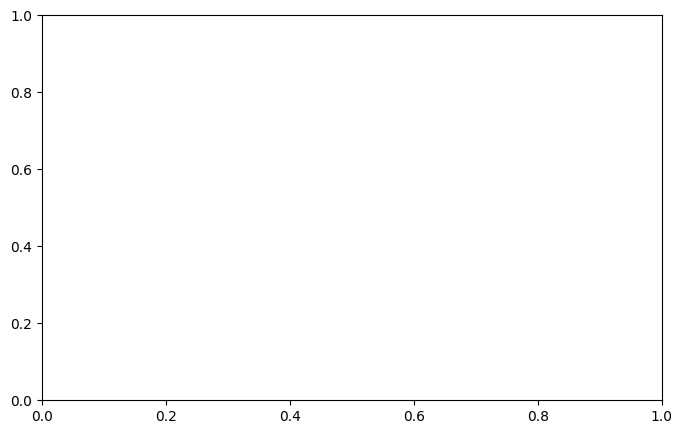

In [31]:
qp = create_quadratic_program(sigma=sigma, mu= mu)


# Run SamplingVQE with the ansatz circuit and COBYLA optimizer
result, cost_history = get_result_SamplingVQE(qp=qp, ansatz=ansatz, optimizer=COBYLA())
qp = create_quadratic_program(sigma=sigma, mu=mu)

get_result_SamplingVQE(qp=qp, ansatz=ansatz, optimizer=COBYLA())
result1, cost_history1 = get_result_SamplingVQE(qp=qp)

# Plot the cost function versus iteration count
plt.figure(figsize=(8, 5))
plt.plot(cost_history["cost"], marker="-", linestyle="-", color="red")
plt.plot(cost_history1["cost"], marker="-", linestyle="-", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function vs Iteration")
plt.grid(True)
plt.show()


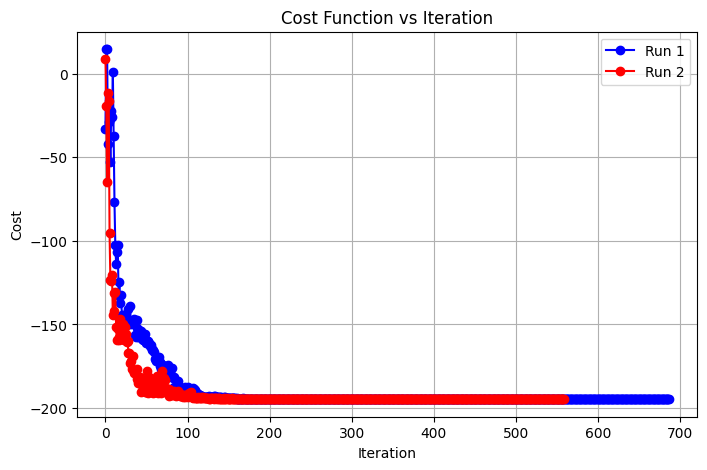

In [59]:
import matplotlib.pyplot as plt


# Assume sigma, mu, create_quadratic_program, build_parametrized_ansatz,
# and get_result_SamplingVQE are defined.

qp = create_quadratic_program(sigma=sigma, mu=mu)

# Run SamplingVQE with the ansatz circuit and COBYLA optimizer for two separate runs.
result, cost_history = get_result_SamplingVQE(qp=qp, ansatz=ansatz, optimizer=COBYLA())
result1, cost_history1 = get_result_SamplingVQE(qp=qp, )

# Plot the cost function versus iteration count for both runs
plt.figure(figsize=(8, 5))
plt.plot(cost_history["cost"], marker="o", linestyle="-", color="blue", label="Run 1")
plt.plot(cost_history1["cost"], marker="o", linestyle="-", color="red", label="Run 2")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function vs Iteration")
plt.grid(True)
plt.legend()
plt.show()
